In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX


### Acknowlegment:

This series of notebooks is based on the datasets and logic provided by Johannes Mauritzen on his GitHub page (https://jmaurit.github.io/). I have closely followed his methods. The original lectures that inspired these notebooks were taught in R, so I adapted his methodology to Python instead. This acknowledgments page applies to all notebooks in this repository. I chose to work with `.ipynb` files because they felt more natural and straightforward than an object-oriented approach for this particular project. 

## Main Chapter Takeaways: (this has been cleaned up in the summary file)
- Datasets used: ETS Carbon Prices (quantity-based “Cap and Trade” form of pricing carbon emissions), NordPool Power Data (DK1 & DK2), Load Data (seasonality)

**First Objective:**
- Model the **mean** of time series assuming a constant variance (homoskedasticity).
- This is done by fitting ARIMA models on power prices to predict power prices in the future (just a single time series). 
- First model assumes price series is assumed to be non-stationary (it is thus integrated once) with a MA process, the other model assumes price series is stationary (with 2 autoregressive terms).
- Forecasting is done for a period of 10 months and the two different forecasts are explained given the model parameters used.
- Traditionally, power markets tend to display $I(1)$ behaviour, i.e. shocks did not use to die out exponentially. Pricing behaviour on power markets tended to follow pricing of commodity fuels (coal and oil), which tend to have price series displaying $I(1)$ behaviour.
- Power markets based on renewables tend to have more stationary tendencies. Shocks, such as weather that affects production, tend to be temporary and with low persistence. 
- We know that the Nordic market as a whole is made up of large shares of renewables (hydro and wind), so we could make the case to use the ARIMA(2,0,0) model, which assumes a stationary price series.
- Some time series, especially high-frequency, tend to have seasonality. This means recurring patterns throughout the day at the hourly, daily, monthly or quarterly levels. 
- The daily power consumption in Norway is imported and weekly seasonality (only) is included in the ARIMA model. 
- Forecasting is done for a period of 30 days with confidence intervals.
- Other seasonalities are ignored and we find that forecasts seem to overrely on the specified seasonal pattern and underestimate the noise.

**Second Objective:**
- Instead of predicting the mean value of the series, the volatility of time series is of interest when analysing power market (e.g. for hedging instruments)


## Univariate forecasting and power markets

### Introduction to time series forecasting and energy

#### Power prices and ETS prices

Johannes Mauritzen obtained carbon prices from UK Think Tank EMBER. The emissions are traded on the EEX exchange and we use this cleaned data.

In [10]:
ets = pd.read_csv("eua-price.csv")

The power data from NordPool is used again.

In [4]:
elspot = pd.read_csv("elspot.csv")

In [31]:
elspot['date'] = pd.to_datetime(elspot['date'])

In [8]:
ets.columns

Index(['Date', 'Price'], dtype='object')

We see the that the power data is monthly, while carbon prices are weekly.

In [26]:
# create new columns inside 'ets' to represent the month and the year in 'Date'
ets_copy = ets.copy()
ets_copy['Date'] = pd.to_datetime(ets_copy['Date'])
ets_copy['month'] = ets_copy['Date'].dt.month
ets_copy['year'] = ets_copy['Date'].dt.year
ets_mon = ets_copy.groupby(['month', 'year'])['Price'].agg('mean').reset_index()

In [27]:
ets_mon['day'] = 1
ets_mon = ets_mon.sort_values(by=['year', 'month'])
ets_mon['date'] = pd.to_datetime(ets_mon[['year', 'month', 'day']])

In [34]:
power_df = pd.merge(elspot, ets_mon[['Price', 'date']], on='date', how='inner')
power_df.to_csv("power_df.csv", index=False)

Focusing on Danish zones

In [39]:
DK_df = power_df[['DK1', 'DK2', 'date', 'Price']]
DK_df = DK_df.rename(columns={"DK1":"DK1_price", "DK2":"DK2_price", "Price":"ets_price"})

In [44]:
DK_df.head()

,DK1_price,DK2_price,date,ets_price
0,5411,4680.0,2008-04-01,25.855625
1,5330,5350.0,2008-05-01,26.805500
2,6711,6886.0,2008-06-01,29.095600
3,6596,6500.0,2008-07-01,27.194500
4,6393,6611.0,2008-08-01,25.712000


Scales of prices: the same in both datasets?

In [45]:
print(DK_df[['DK1_price', 'DK2_price']])
print(ets_mon['Price'])

     DK1_price  DK2_price
0         5411     4680.0
1         5330     5350.0
2         6711     6886.0
3         6596     6500.0
4         6393     6611.0
..         ...        ...
123       5569     5684.0
124       4989     5179.0
125       4748     5090.0
126       5404     5468.0
127       4670     4911.0

[128 rows x 2 columns]
35     25.855625
46     26.805500
58     29.095600
70     27.194500
82     25.712000
         ...    
117    24.930500
129    24.525000
141    25.259900
11     24.401000
23     23.225000
Name: Price, Length: 142, dtype: float64


We see that the prices for DK1 and DK2 are in 1000's of Euros (DK_df). This indicates that the units are in EUR/MWh. The units should be converted to EUR/KWh so that the scale is similar to the carbon prices in monthly carbon prices (ets_mon)

In [46]:
DK_df["DK1_price"] = DK_df["DK1_price"] / 1000
DK_df["DK2_price"] = DK_df["DK2_price"] / 1000

In [47]:
DK_df.head()

,DK1_price,DK2_price,date,ets_price
0,5.411,4.680,2008-04-01,25.855625
1,5.330,5.350,2008-05-01,26.805500
2,6.711,6.886,2008-06-01,29.095600
3,6.596,6.500,2008-07-01,27.194500
4,6.393,6.611,2008-08-01,25.712000


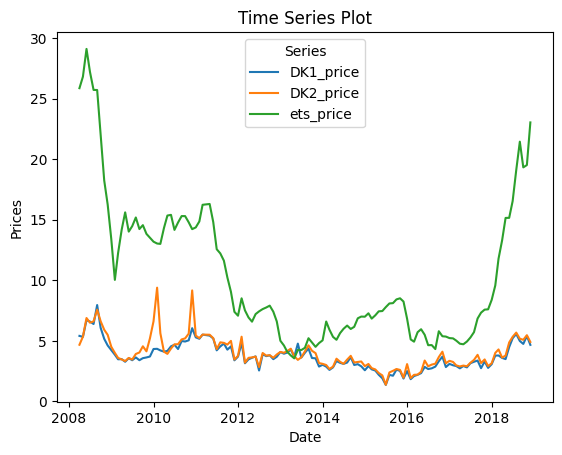

In [49]:
melted_df = pd.melt(DK_df, id_vars=['date'], var_name='series', value_name='prices')

sns.lineplot(x='date', y='prices', data=melted_df, hue='series')

plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(title="Series")
plt.show() 

If we'd kept the `ets_price` series in 1000's of Euros per MWh, we could have used subplots and `ax2 = ax1.twinx` to use same x-axis but secondary y-axis for different scale or units.

It seems as though there is a slight correlation. Carbon prices and electricity prices in Denmark seem to move in similar directions. Between 2014 and 2016, however, carbon prices increase as electricity prices in Denmark go down.

### Forecasting with ARIMA models

The goal is to **create a forecasting model for predicting power prices**. 

ARIMA models: AR (autoregressive), I (integrated), MA (moving average)

The AR model models a variable as a function of its own lagged values.

The MA model models the dynamics of the model's error terms (or shocks of the model), not the actual values of the time series. 

The MA(1) model,
$$
y_t = c + \epsilon_t + \epsilon_{t-1}.
$$

The MA(2) model,
$$
y_t = c + \epsilon_t + \epsilon_{t-1} + \epsilon_{t-2}.
$$

The intuition behind this model is that exogenous shocks can carry on to later periods. For example, the shocks to the oil price due to the coronavirus pandemic carries on for many more months or even years.

In the MA process, shocks are finite. For MA(2), shocks will last two periods and exit the system. 

In the AR process, for example AR(1), a shock will stay in the system indefinitely. Such a process undergoes exponential decay and quickly dies out. 

All MA models can be written as AR models and vice versa.  

#### ARIMA modelling of Power Prices

In [60]:
DK_df.set_index('date', inplace=True)
DK_df.index = pd.to_datetime(DK_df.index)
DK_df.index = DK_df.index.to_period('M')

KeyError: "None of ['date'] are in the columns"

In [61]:
DK_df.index = DK_df.index.to_timestamp()

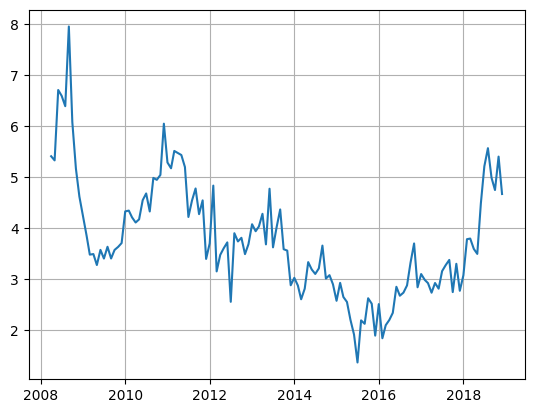

In [62]:
plt.figure()
plt.plot(DK_df.index, DK_df['DK1_price'])
plt.grid(True)
plt.show()

Does not look very stationary, so check for presence of unit-root process.

In [71]:
adf_result = adfuller(DK_df['DK1_price'])

print("ADF Statistic: ", adf_result[0])
print("p-value:       ", adf_result[1])
print("Used lags:     ", adf_result[2])
print("Number of observations used:", adf_result[3])

# Optional: the ADF function also returns critical values and an IC best fit.
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}, {value}")

ADF Statistic:  -2.6871527707679332
p-value:        0.07628790715791335
Used lags:      2
Number of observations used: 124
Critical Values:
   1%, -3.484219653271961
   5%, -2.885145235641637
   10%, -2.579359138917794


It appears as though the series is slightly non-stationary, as p-value of 0.07 exceeds the threshold of 5%, so the first difference is taken.

In [65]:
DK_df['d_DK1_price'] = DK_df['DK1_price'].diff()
DK_df.dropna(subset=['d_DK1_price'], inplace=True)

Plot differenced series, ACF and PACF 

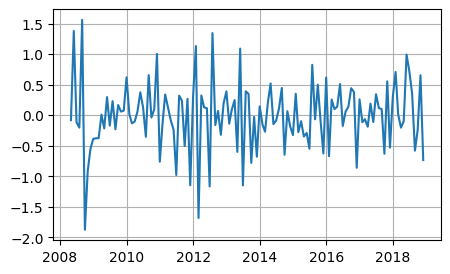

In [68]:
plt.figure(figsize=(5,3))
plt.plot(DK_df['d_DK1_price'])
plt.grid(True)
plt.show()

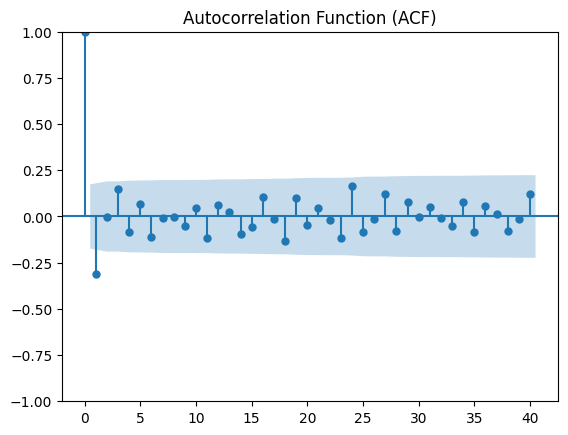

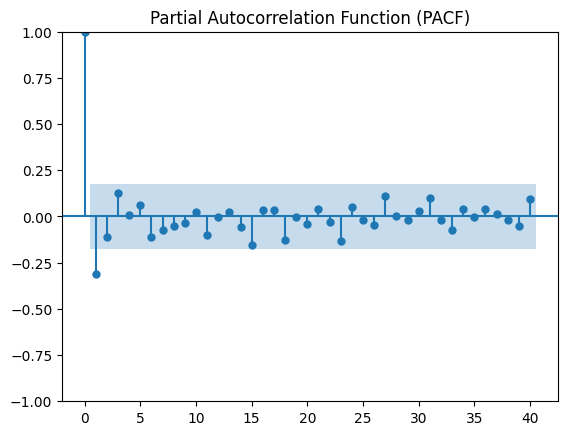

In [73]:
# Plot ACF (Autocorrelation Function)
plot_acf(DK_df['d_DK1_price'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF (Partial Autocorrelation Function)
plot_pacf(DK_df['d_DK1_price'], lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**MA order (q)** $\rightarrow$ identified from the **ACF**

**AR order (p)** $\rightarrow$ identified from the **pACF**

In both instances, lag 0 is the correlation with the series with itself, so only lags 1, 2, and so on... are considered. We choose values of $p=q=1$. There is negative autocorrelation on the first lag in the acf. 

Summarising, the appropriate ARIMA model order is,

$$
\text{ARIMA}(p, d, q) = \text{ARIMA}(1, 1, 1).
$$
The algorithm is also allowed to choose the optimal ARIMA model.

In [80]:
# fit ARIMA(1,1,1)
model_arima111 = pm.ARIMA(order=(1,1,1))
model_arima111 = model_arima111.fit(DK_df['DK1_price'])

# fit ARIMA automatically using best parameters
model_automatic = pm.auto_arima(
    DK_df['DK1_price'],
    start_p=0, max_p=5,       # range of AR orders to try
    start_q=0, max_q=5,       # range of MA orders to try
    d=1,                      # you already suspect one difference is needed
    seasonal=False,           # set to True if you have seasonal data
    trace=False,              # set to True for verbose output
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True             # stepwise search to speed up
)

# Gather results for comparison
models = {
    'arima111':  model_arima111,
    'automatic': model_automatic
}

# results table
results = []
for model_name, fitted_model in models.items():
    # pmdarima models offer .aic(), .bic(), .aicc() methods
    results.append({
        'model': model_name,
        'AIC':   fitted_model.aic(),
        'AICc':  fitted_model.aicc() if hasattr(fitted_model, 'aicc') else None,
        'BIC':   fitted_model.bic()
    })

df_results = pd.DataFrame(results)
df_results.sort_values('AICc', inplace=True, ignore_index=True)

print(df_results)

# identify the best model 
best_model = df_results.iloc[0]['model']
print(f"The best model based on AIC/AICc/BIC is: {best_model}")

p, d, q = model_automatic.order
print(f"Automatically selected (p, d, q) = ({p}, {d}, {q})")

print(model_automatic.summary())

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


       model         AIC        AICc         BIC
0  automatic  197.382504  197.479278  203.055068
1   arima111  200.761959  201.089827  212.107086
The best model based on AIC/AICc/BIC is: automatic
Automatically selected (p, d, q) = (0, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -96.691
Date:                Fri, 27 Dec 2024   AIC                            197.383
Time:                        12:31:54   BIC                            203.055
Sample:                             0   HQIC                           199.687
                                - 127                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

The ARIMA(0,1,1) model seems to perform the best as it was chosen by the automatic model. It's only considering a single time series.

The `ma.L1` `coef` has a value of $-0.32$.

The "shock" is the residual (error term), $\epsilon_t$, for $y_t$ at time $t$.

The Moving Average model of order 1 is represented by,
$$
y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1}
$$

Here, $\theta_1$ is negative ($\theta_1 = -0.32$), indicating a positive shock at time $t-1$ tends to be followed by a negative change at time $t$ and vice versa. Model sees a tendency for successive residuals to move in opposite directions. 

The "shock" is the part of $y_t$ that was not predicted by the model at time $t$.

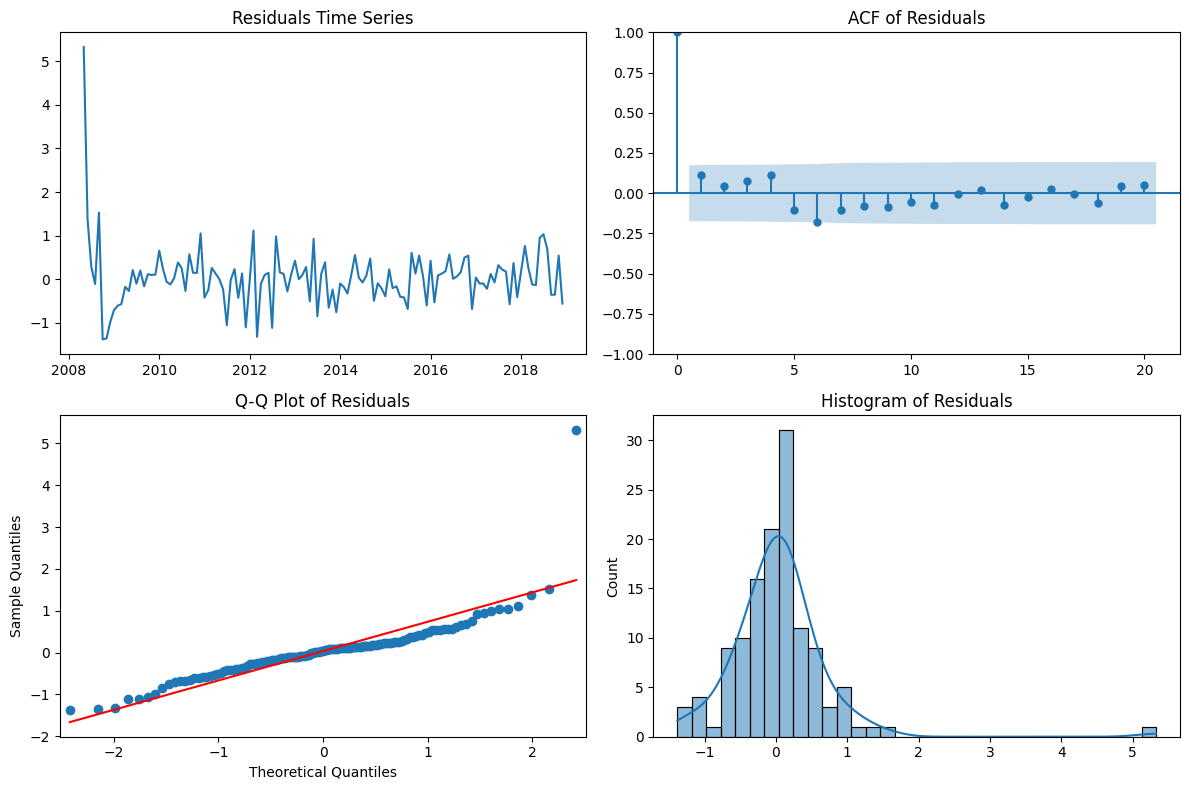

In [83]:
resids = model_automatic.resid()

fig, axes = plt.subplots(2, 2, figsize=(12,8))

# time series plot of residuals
axes[0,0].plot(resids)
axes[0,0].set_title("Residuals Time Series")

plot_acf(resids, ax=axes[0, 1], lags=20, title="ACF of Residuals")

# 3) Q-Q plot of residuals
sm.qqplot(resids, line='s', ax=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot of Residuals")

# 4) Histogram of residuals
sns.histplot(resids, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Histogram of Residuals")

plt.tight_layout()
plt.show()

1. Residuals hover around zero without a clear trend or seasonality left. This suggests the model has captured most of the time-dependent structure.
2. Most of the inidividual autocorrelations fall within the confidence bands. There is little to no remaining autocorrelation. 
3. Q-Q plot of residuals. The residuals are mostly normal. 
4. Same conclusion.
Could examine the outlier at +5. 

We remind ourselves that the analysis was done on the differenced time series of DK1 electricity price. Doing so throws away information, such as:
1. The absolute magnitude of the series is lost.
2. The trend that is removed may contain valuable information
3. Difference may magnify high-frequency noise 
4. Forecasts require you to "integrate", sum up the differences, to get back to the original scale. Each integration step accumulates errors, leading to increased uncertainty in the final forecast. 

The autocorrelation analysis is repeated with the original time series.

In [85]:
DK_df.columns

Index(['DK1_price', 'DK2_price', 'ets_price', 'd_DK1_price'], dtype='object')

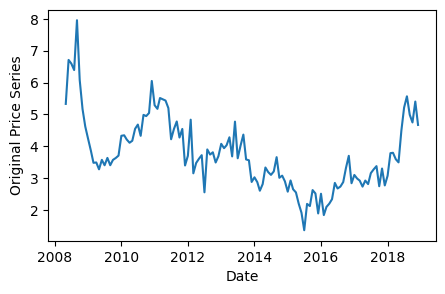

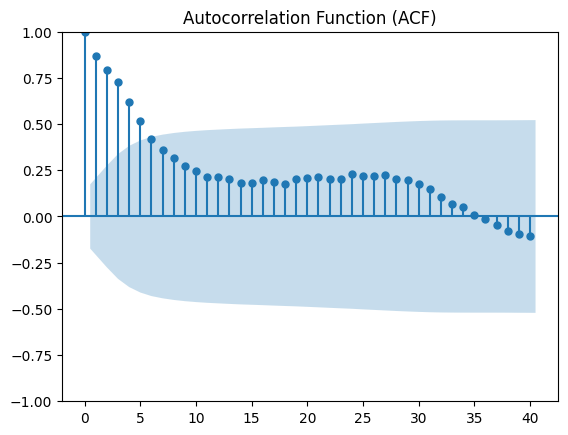

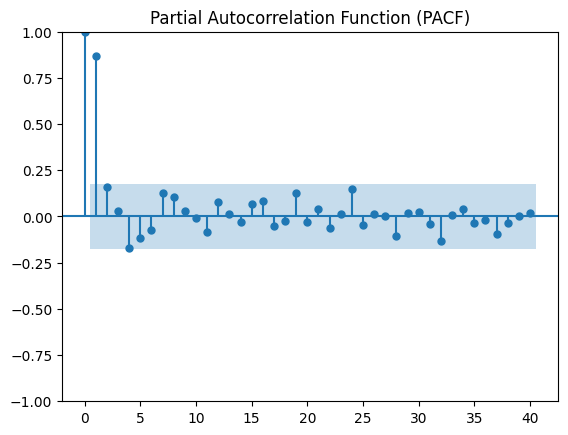

In [86]:
plt.figure(figsize=(5,3))
plt.plot(DK_df['DK1_price'])
plt.xlabel('Date')
plt.ylabel('Original Price Series')
plt.show()

# Plot ACF (Autocorrelation Function)
plot_acf(DK_df['DK1_price'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF (Partial Autocorrelation Function)
plot_pacf(DK_df['DK1_price'], lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**ACF** can be dominated by a trend or seasonal structure (leading to slow or wavy decay). The exponentially decaying pattern is typical of a simple AR process.

**pACF** spikes only if there is a direct AR relationship at that specific lag.

For the non-differenced price series DK1_price, there is no strong cut-off in the ACF plot, which indicates there is little evidence for a pure MA(q) component. The slow decaying tail is typical of an AR process. So it is MA(0). The pACF has large spikes at lag 1 (possibly lag 2), classic evidence of AR(p) process. I(0) is chosen given that the series will not be integrated here. The chosen model is therefore,
$$
\text{ARIMA}(p, d, q) = \text{ARIMA}(1, 0, 0).
$$
The algorithm is also allowed to choose the optimal ARIMA model. 

In [90]:
# fit ARIMA(2,0,0)
model_arima200 = pm.ARIMA(order=(2,0,0)) # AR(2), I(0), MA(0)
model_arima200 = model_arima200.fit(DK_df['DK1_price'])

# fit RIMA(1,0,0)
model_arima100 = pm.ARIMA(order=(1,0,0)) # AR(1), I(0), MA(0)
model_arima100 = model_arima100.fit(DK_df['DK1_price'])

# fit ARIMA automatically using best parameters
model_automatic = pm.auto_arima(
    DK_df['DK1_price'],
    start_p=0, max_p=5,       # range of AR orders to try
    start_q=0, max_q=5,       # range of MA orders to try
    d=1,                      # you already suspect one difference is needed
    seasonal=False,           # set to True if you have seasonal data
    trace=False,              # set to True for verbose output
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True             # stepwise search to speed up
)

# Gather results for comparison
models = {
    'arima100': model_arima100,
    'arima200':  model_arima200,
    'automatic': model_automatic
}

# results table
results = []
for model_name, fitted_model in models.items():
    # pmdarima models offer .aic(), .bic(), .aicc() methods
    results.append({
        'model': model_name,
        'AIC':   fitted_model.aic(),
        'AICc':  fitted_model.aicc() if hasattr(fitted_model, 'aicc') else None,
        'BIC':   fitted_model.bic()
    })

df_results = pd.DataFrame(results)
df_results.sort_values('AICc', inplace=True, ignore_index=True)

print(df_results)

# identify the best model 
best_model = df_results.iloc[0]['model']
print(f"The best model based on AIC/AICc/BIC is: {best_model}")

p, d, q = model_automatic.order
print(f"Automatically selected (p, d, q) = ({p}, {d}, {q})")

print(model_arima200.summary()) # 208.557662  208.752784  217.090224

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


       model         AIC        AICc         BIC
0  automatic  197.382504  197.479278  203.055068
1   arima200  201.147259  201.475128  212.524008
2   arima100  208.557662  208.752784  217.090224
The best model based on AIC/AICc/BIC is: automatic
Automatically selected (p, d, q) = (0, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -96.574
Date:                Fri, 27 Dec 2024   AIC                            201.147
Time:                        15:01:13   BIC                            212.524
Sample:                             0   HQIC                           205.769
                                - 127                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

Both ARIMA(2,0,0) and ARIMA(1,0,0) were fitted and ARIMA(2,0,0) performed the best out of the two models. It is ultimately picked here. The automatic model still integrates the series as done in the previous step. 

Goodness of fit measures can only be compared between models where the series values are untransformed. Taking the difference of the series rescales the data.

The residuals are analysed again.

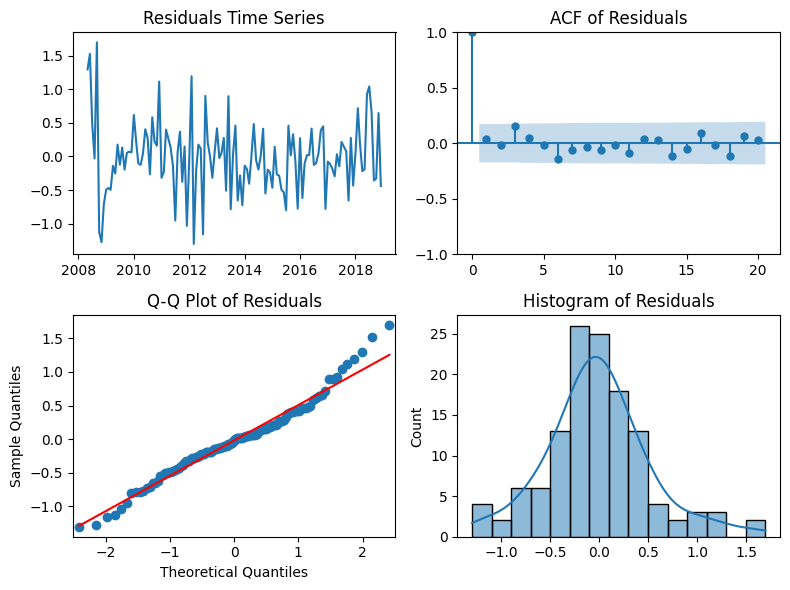

In [91]:
resids = model_arima200.resid()

fig, axes = plt.subplots(2, 2, figsize=(8,6))

# time series plot of residuals
axes[0,0].plot(resids)
axes[0,0].set_title("Residuals Time Series")

plot_acf(resids, ax=axes[0, 1], lags=20, title="ACF of Residuals")

# 3) Q-Q plot of residuals
sm.qqplot(resids, line='s', ax=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot of Residuals")

# 4) Histogram of residuals
sns.histplot(resids, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Histogram of Residuals")

plt.tight_layout()
plt.show()

1. Residuals look good, centred around zero.
2. No significant correlations in the ACF plot 
3. Normally distributed according to Q-Q plot
4. No significant outlier like in the differenced histogram

Use both models for forecasting using the best model for differenced price series ARIMA(0,1,1) and for price series directly ARIMA(2,0,0). One model, of course, takes the first difference, while the other does not. 

1. ARIMA(0,1,1) (model_automatic)

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported 

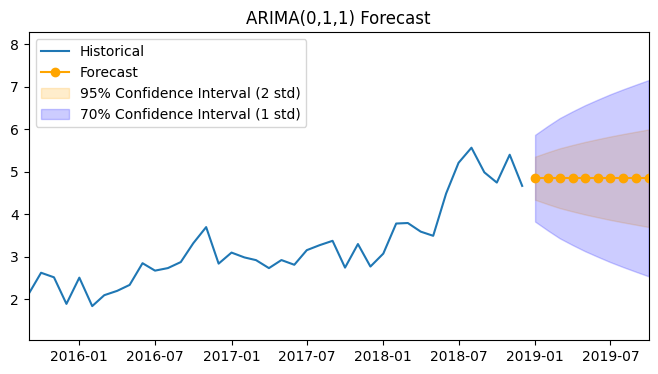

In [151]:
n_periods = 10
#forecast, confint = model_automatic.predict(n_periods=n_periods, return_conf_int=True)

# TRY MULTIPLE CONFIDENCE INTERVALS ON THE SAME PLOT 
forecast, confint_95 = model_automatic.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)  # 95%
forecast, confint_80 = model_automatic.predict(n_periods=n_periods, return_conf_int=True, alpha=0.33)  # 80%

# create index for the forecast that continues from the end of the original series
last_index = DK_df['DK1_price'].index[-1]

forecast_index = pd.date_range(start=last_index, periods=n_periods+1, freq='MS')[1:] # ensure first day of month with 'MS'
forecast.index = forecast_index # 'forecast' Series had a different index so was not matching in the 'df_forecast' DataFrame

# forecast and confidence intervals into a dataframe
df_forecast_95 = pd.DataFrame({
    'forecast':forecast,
    'lower':confint_80[:, 0],
    'upper':confint_80[:, 1]
}, index=forecast_index)

df_forecast_80 = pd.DataFrame({
    'forecast':forecast,
    'lower':confint_95[:, 0],
    'upper':confint_95[:, 1]
}, index=forecast_index)

# plot historical data and forecast
plt.figure(figsize=(8,4))
# plot original series
plt.plot(DK_df['DK1_price'].index, DK_df['DK1_price'], label="Historical")

# plot forecast
plt.plot(df_forecast_95.index, df_forecast_95['forecast'], label='Forecast', color='orange', marker='o')

plt.fill_between(
    df_forecast_95.index,
    df_forecast_95['lower'],
    df_forecast_95['upper'],
    color='orange',
    alpha=0.2,
    label='95% Confidence Interval (2 std)'
)

# Plot 80% confidence interval
plt.fill_between(
    df_forecast_80.index,
    df_forecast_80['lower'],
    df_forecast_80['upper'],
    color='blue',
    alpha=0.2,
    label='70% Confidence Interval (1 std)'
)

# ensure that the forecast is visible (was not with code above only) so ensure x-range includes forecast indices, too
all_x = pd.concat([DK_df['DK1_price'].index.to_series(), df_forecast_95.index.to_series()])
"""
all_y = pd.concat([
    DK_df['DK1_price'],
    df_forecast['forecast'],
    df_forecast['lower'],
    df_forecast['upper']
])
plt.ylim(all_y.min(), all_y.max())
"""

plt.xlim(all_x[-50], all_x.max())

plt.legend(loc='upper left')
plt.title("ARIMA(0,1,1) Forecast")
plt.show()

Only the last 50 months of the data are included for better visibility

2. ARIMA(2,0,0)

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported 

/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_79000/675943098.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(all_x[-50], all_x.max())


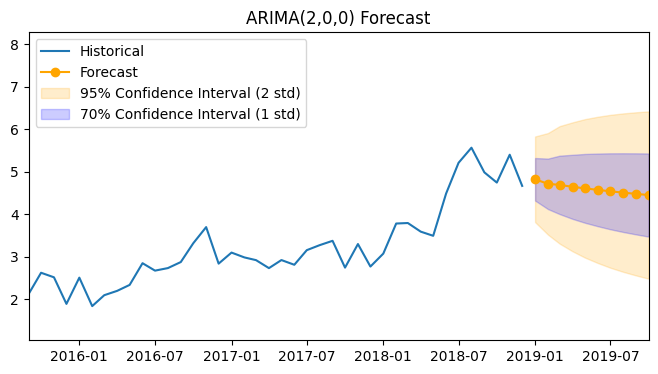

In [152]:
n_periods = 10 # months
forecast, confint95 = model_arima200.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)
forecast, confint80 = model_arima200.predict(n_periods=n_periods, return_conf_int=True, alpha=0.33)

# create index for the forecast that continues from the end of the original series
last_index = DK_df['DK1_price'].index[-1]

forecast_index = pd.date_range(start=last_index, periods=n_periods+1, freq='MS')[1:] # ensure first day of month with 'MS'
forecast.index = forecast_index # 'forecast' Series had a different index so was not matching in the 'df_forecast' DataFrame

# forecast and confidence intervals into a dataframe
df_forecast_95 = pd.DataFrame({
    'forecast':forecast,
    'lower':confint95[:, 0],
    'upper':confint95[:, 1]
}, index=forecast_index)

df_forecast_80 = pd.DataFrame({
    'forecast':forecast,
    'lower':confint80[:, 0],
    'upper':confint80[:, 1]
}, index=forecast_index)

# plot historical data and forecast
plt.figure(figsize=(8,4))
# plot original series
plt.plot(DK_df['DK1_price'].index, DK_df['DK1_price'], label="Historical")

# plot forecast
plt.plot(df_forecast_95.index, df_forecast_95['forecast'], label='Forecast', color='orange', marker='o')

plt.fill_between(
    df_forecast_95.index,
    df_forecast_95['lower'],
    df_forecast_95['upper'],
    color='orange',
    alpha=0.2,
    label='95% Confidence Interval (2 std)'
)

plt.fill_between(
    df_forecast_80.index,
    df_forecast_80['lower'],
    df_forecast_80['upper'],
    color='blue',
    alpha=0.2,
    label='70% Confidence Interval (1 std)'
)

# ensure that the forecast is visible (was not with code above only) so ensure x-range includes forecast indices, too
all_x = pd.concat([DK_df['DK1_price'].index.to_series(), df_forecast_95.index.to_series()])
"""
all_y = pd.concat([
    DK_df['DK1_price'],
    df_forecast['forecast'],
    df_forecast['lower'],
    df_forecast['upper']
])
plt.ylim(all_y.min(), all_y.max())
"""

plt.xlim(all_x[-50], all_x.max())
plt.legend(loc='upper left')
plt.title("ARIMA(2,0,0) Forecast")
plt.show()

Confidence Intervals:
- Confidence intervals are almost certaintly under-estimated. Uncertainty is calculated based on the **known past** of the series, whereas the future contains **many unknowns**. This point is made by Johannes Moritzen, however, I am unsure how this statement is any different from the bias-variance tradeoff of any predictive model. Future is always uncertain. All models are bad, but some are useful.

Model forecasts:
1. ARIMA(0,1,1)'s first prediction is above the last historical data point and then propagates this value for all 10 months
2. ARIMA(2,0,0) forecasts a downward trend for the next 10 months. 

**Why may explain this difference?**

1. In a $I(1)$ process, e.g. weakly dependent process such as random walk, each new value in the series is determined by adding a random shock to the previous value. Once a shock occurs, it has a lasting effect on the series. The shock does not disappear over time, it *persists*. The series "drifts" in the direction of those shocks. Therefore, the best forecast for the following period is the value of the previous period. Hence the flat predictions of ARIMA(0,1,1).
2. In ARIMA(2,0,0), only the AR terms are kept. The $I(0)$ term implies that the series is stationary. A stationary time series is one where statistical properties, such as the mean, variance, and autocorrelations are constant over time. As opposed to a $I(1)$ process, in an AR process, shocks do not have a permanent effect. Instead, after a shock occurs, the time series tends to revert back to its mean over time. Also known as mean reversion. If such a process is assumed, then our best forecast would be that the jump seen from 01-2018 until 12-2018 will eventually die out and mean-revert. This is what the forecast is showing by giving the downward trend. 

**Which is best?**

The goodness of fit measures (AIC, BIC) cannot be compared here between an integrated model and a non-integrated model. The likelihoods for integration/ non-integration will be of different scales. Tests of stationarity were also around the threshold, thus not conclusive. 

**How to improve the decision?**

- Add more data to conclusively decide if the price series is stationary or not. 
- "Domain" knowledge of power markets?

**Power Market Knowledge:**

- Traditionally, power markets tend to display $I(1)$ behaviour, i.e. shocks did not use to die out exponentially. Pricing behaviour on power markets tended to follow pricing of commodity fuels (coal and oil), which tend to have price series displaying $I(1)$ behaviour
- Power markets based on renewables tend to have more stationary tendencies. Shocks, such as weather that affects production, tend to be temporary and with low persistence. 
- We know that the Nordic market as a whole is made up of large shares of renewables (hydro and wind), so we could make the final decision of using the ARIMA(2,0,0) model, which assumes a stationary price series. 


### Seasonality

Some time series, especially high-frequency, tend to have seasonality. This means recurring patterns throughout the day at the hourly, daily, monthly or quarterly level. 

Daily consumption data (load data) is imported, as it usually shows strong seasonality.

In [157]:
cons = pd.read_csv("consumption-per-country_2019_daily.csv", sep=';')
cons['date'] = pd.to_datetime(cons['date'], format='%d/%m/%Y')

In [166]:
cons = cons.set_index('date')

Norwegian Consumption is plotted

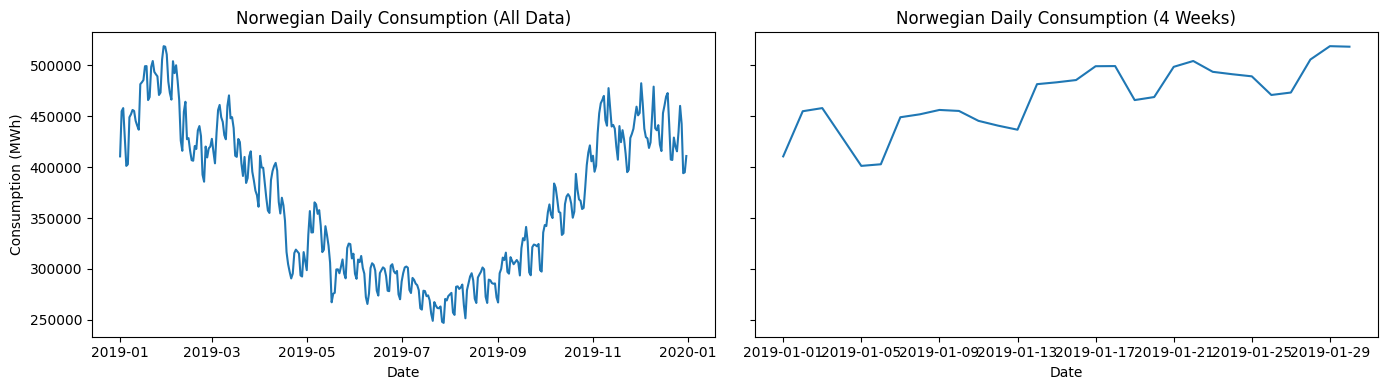

In [176]:
# Define the figure and the two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# Plot 1: The entire dataset
axes[0].plot(cons.index, cons['NO'])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Consumption (MWh)')
axes[0].set_title('Norwegian Daily Consumption (All Data)')

# Plot 2: Zoomed in to 3 weeks
axes[1].plot(cons.index[:30], cons['NO'][:30])
axes[1].set_xlabel('Date')
axes[1].set_title('Norwegian Daily Consumption (4 Weeks)')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

Straight away, two kinds of seasonalities can be spotted here:

- Left: Yearly seasonal pattern, defined by higher consumption in the winter months and lower consumption in the summer period. As data only contains one years' worth, it cannot be extrapolated to all other years, but the pattern is expected if multiple years' worth of data were plotted.

- Right: Weekly seasonal pattern, where consumption drops off on the weekend (reduced industrial demand, though there are exceptions to this trend depending on the location, types of economies etc.). Just to make, sure we can filter weekdays and weekends to ensure that our hypothesis is correct.

In [187]:
cons_weekends = cons.copy()
cons_weekends['day_of_week'] = cons_weekends.index.dayofweek
cons_weekends['is_weekend'] = cons_weekends['day_of_week'] >= 5

cons_weekends.groupby('is_weekend')['NO'].agg('mean').reset_index().rename(columns={'NO':'avg_daily_consumption'})

   is_weekend  avg_daily_consumption
0       False          372608.735632
1        True          348330.134615


"\naverage_weekday = cons_weekends[~cons_weekends['is_weekend'], 'NO'].mean()\naverage_weekend = cons_weekends[cons_weekends['is_weekend'], 'NO'].mean()\nprint(average_weekday)\n"

Daily consumption is indeed lower than on weekdays (348k MWh vs. 372 MWh), which supports the hypothesis that there is a weakly seasonal pattern. Because we only have a single year's worth of data and hence cannot analyse yearly seasonal pattern,taking  weekly seasonal pattern into account is the focus of this chapter.

The `statsmodels` library, specifically the `seasonal_decompose` or `STL` classes. `STL` class stands for Seasonal and Trend decomposition using Loess (Loess is a local non-linear regression technique).

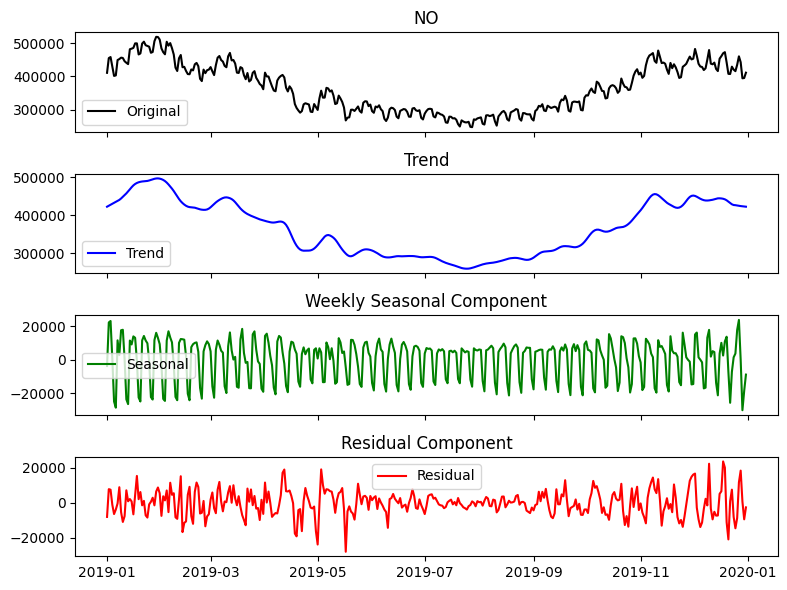

In [194]:
stl = STL(cons['NO'], seasonal=7) # seasonal=7 because it is a weakly seasonal pattern
result = stl.fit()

# extract components of fitted model
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

# Original series
axes[0].plot(cons.index, cons['NO'], label='Original', color='black')
axes[0].set_title('NO')
axes[0].legend()

# Trend
axes[1].plot(cons.index, trend, label='Trend', color='blue')
axes[1].set_title('Trend')
axes[1].legend()

# Seasonal
axes[2].plot(cons.index, seasonal, label='Seasonal', color='green')
axes[2].set_title('Weekly Seasonal Component')
axes[2].legend()

# Residual
axes[3].plot(cons.index, residual, label='Residual', color='red')
axes[3].set_title('Residual Component')
axes[3].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The seasonally adjusted series is extracted. The seasonal component is removed. The series left is composed of the trend and non-seasonal errors. 

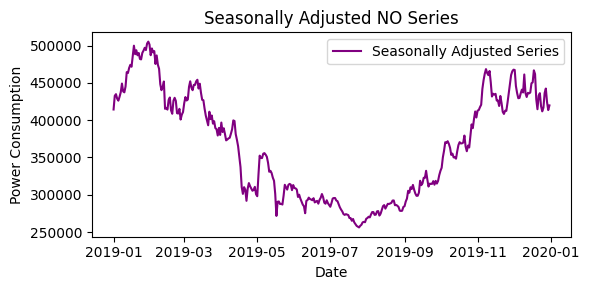

In [195]:
cons['NO_sa'] = cons['NO'] - seasonal

# Plot the seasonally adjusted series
plt.figure(figsize=(6, 3))
plt.plot(cons.index, cons['NO_sa'], label='Seasonally Adjusted Series', color='purple')
plt.title('Seasonally Adjusted NO Series')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.tight_layout()
plt.show()

Options:
1. Create a forecast from the seasonally adjusted series (`NO_sa`)
2. Model the seasonality in ARIMA model directly to include the seasonality in the forecast.

Option 2 is carried out below. The data is non-stationary so a seasonal difference (7 days) is taken as opposed to a first difference (1 day). Plot this seasonally differenced series and call ACF and pACF functions.

First, take only single difference and test for stationarity using the ADF test, to illustrate the effect of a weekly seasonal pattern on the first difference...

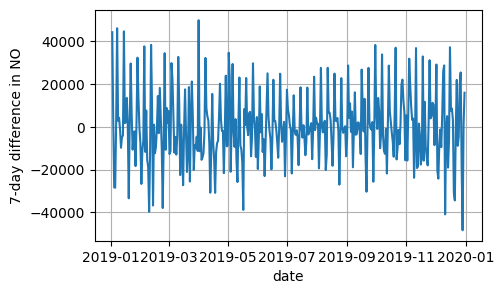

ADF Statistic: -5.56966046202241
p-value: 1.47732440850767e-06
Critical Values: {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
The series is stationary (reject the null hypothesis).


In [205]:
plt.figure(figsize=(5,3))
plt.plot(cons['NO'].diff(periods=1).dropna().index, cons['NO'].diff(periods=1).dropna())
plt.xlabel('date')
plt.ylabel('7-day difference in NO')
plt.grid(True)
plt.show()

# Perform the Augmented Dickey-Fuller (ADF) test on the one-time differenced series
result = adfuller(cons['NO'].diff(periods=1).dropna())

# Extract test statistics
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpret the results
if result[1] <= 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is not stationary (fail to reject the null hypothesis).")

Integrating once does make the series stationary, but the 7-day difference approach is used anyhow.

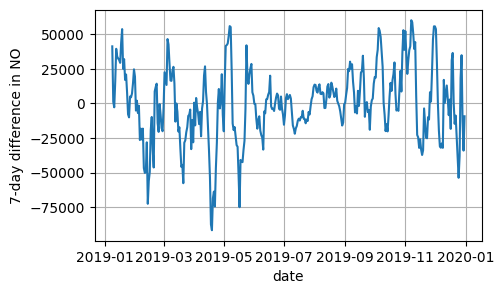

<Figure size 500x300 with 0 Axes>

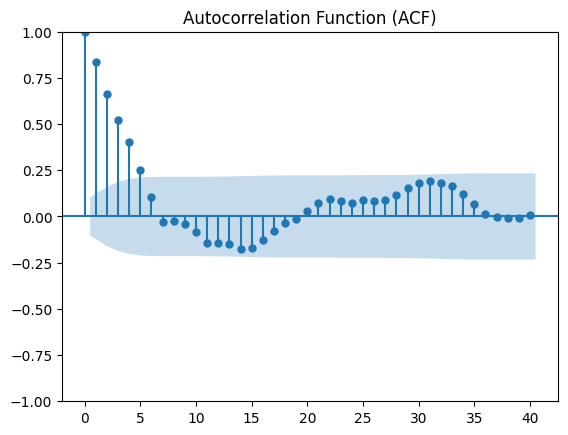

<Figure size 500x300 with 0 Axes>

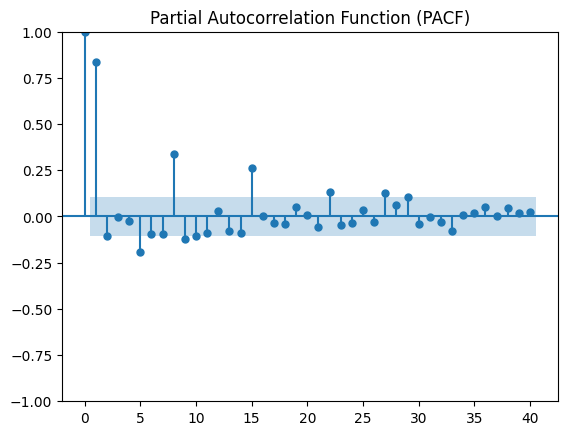

In [207]:
plt.figure(figsize=(5,3))
plt.plot(cons['NO'].diff(periods=7).dropna().index, cons['NO'].diff(periods=7).dropna())
plt.xlabel('date')
plt.ylabel('7-day difference in NO')
plt.grid(True)
plt.show()

 # Plot ACF (Autocorrelation Function)
plt.figure(figsize=(5,3))
plot_acf(cons['NO'].diff(periods=7).dropna(), lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF (Partial Autocorrelation Function)
plt.figure(figsize=(5,3))
plot_pacf(cons['NO'].diff(periods=7).dropna(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Let program automatically choose the best ARIMA model (WITH seasonality this time)

In [223]:
# fit ARIMA(2,0,0)
"""
model_arima200 = pm.ARIMA(order=(2,0,0)) # AR(2), I(0), MA(0)
model_arima200 = model_arima200.fit(DK_df['DK1_price'])

# fit RIMA(1,0,0)
model_arima100 = pm.ARIMA(order=(1,0,0)) # AR(1), I(0), MA(0)
model_arima100 = model_arima100.fit(DK_df['DK1_price'])
"""

# fit ARIMA automatically using best parameters
model_automatic = pm.auto_arima(
    cons['NO'],
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=1,
    seasonal=True,            # seasonal ARIMA
    m=7,                      # Weekly seasonality i.e. 7 days
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    D=1,
    trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Gather results for comparison
models = {
    'automatic': model_automatic
}

# results table
results = []
for model_name, fitted_model in models.items():
    # pmdarima models offer .aic(), .bic(), .aicc() methods
    results.append({
        'model': model_name,
        'AIC':   fitted_model.aic(),
        'AICc':  fitted_model.aicc() if hasattr(fitted_model, 'aicc') else None,
        'BIC':   fitted_model.bic()
    })

df_results = pd.DataFrame(results)
df_results.sort_values('AICc', inplace=True, ignore_index=True)

print(df_results)

# identify the best model 
best_model = df_results.iloc[0]['model']
print(f"The best model based on AIC/AICc/BIC is: {best_model}")

p, d, q = model_automatic.order
print(f"Automatically selected (p, d, q) = ({p}, {d}, {q})")

print(model_automatic.summary()) # 208.557662  208.752784  217.090224

       model          AIC        AICc          BIC
0  automatic  7794.232149  7794.39928  7813.620828
The best model based on AIC/AICc/BIC is: automatic
Automatically selected (p, d, q) = (0, 1, 1)
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  365
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -3892.116
Date:                           Sat, 28 Dec 2024   AIC                           7794.232
Time:                                   22:18:56   BIC                           7813.621
Sample:                               01-01-2019   HQIC                          7801.944
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

30 days are forecasted ahead based on the seasonal ARIMA model found automatically by the model. 

/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_79000/1384406166.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(all_x[-100], all_x.max())


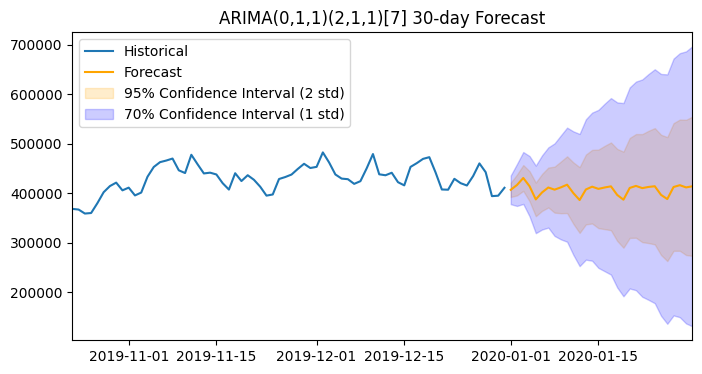

In [224]:
n_periods = 30
#forecast, confint = model_automatic.predict(n_periods=n_periods, return_conf_int=True)

# TRY MULTIPLE CONFIDENCE INTERVALS ON THE SAME PLOT 
forecast, confint_95 = model_automatic.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)  # 95%
forecast, confint_80 = model_automatic.predict(n_periods=n_periods, return_conf_int=True, alpha=0.33)  # 80%

# create index for the forecast that continues from the end of the original series
last_index = cons['NO'].index[-1]

forecast_index = pd.date_range(start=last_index, periods=n_periods+1, freq='D')[1:] # ensure first day of month with 'MS'
forecast.index = forecast_index # 'forecast' Series had a different index so was not matching in the 'df_forecast' DataFrame

# forecast and confidence intervals into a dataframe
df_forecast_95 = pd.DataFrame({
    'forecast':forecast,
    'lower':confint_80[:, 0],
    'upper':confint_80[:, 1]
}, index=forecast_index)

df_forecast_80 = pd.DataFrame({
    'forecast':forecast,
    'lower':confint_95[:, 0],
    'upper':confint_95[:, 1]
}, index=forecast_index)

# plot historical data and forecast
plt.figure(figsize=(8,4))
# plot original series
plt.plot(cons['NO'].index, cons['NO'], label="Historical")

# plot forecast
plt.plot(df_forecast_95.index, df_forecast_95['forecast'], label='Forecast', color='orange')

plt.fill_between(
    df_forecast_95.index,
    df_forecast_95['lower'],
    df_forecast_95['upper'],
    color='orange',
    alpha=0.2,
    label='95% Confidence Interval (2 std)'
)

# Plot 80% confidence interval
plt.fill_between(
    df_forecast_80.index,
    df_forecast_80['lower'],
    df_forecast_80['upper'],
    color='blue',
    alpha=0.2,
    label='70% Confidence Interval (1 std)'
)

# ensure that the forecast is visible (was not with code above only) so ensure x-range includes forecast indices, too
all_x = pd.concat([cons['NO'].index.to_series(), df_forecast_95.index.to_series()])
"""
all_y = pd.concat([
    DK_df['DK1_price'],
    df_forecast['forecast'],
    df_forecast['lower'],
    df_forecast['upper']
])
plt.ylim(all_y.min(), all_y.max())
"""

plt.xlim(all_x[-100], all_x.max())

plt.legend(loc='upper left')
plt.title("ARIMA(0,1,1)(2,1,1)[7] 30-day Forecast")
plt.show()

Let's try by removing the $I(1)$ part, and forecasting using an ARIMA(2,0,1) model

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/var/folders/g2/l186zykd1g56mc9vp1p2rv280000gn/T/ipykernel_79000/1783879191.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim(all_x[-100], all_x.max())


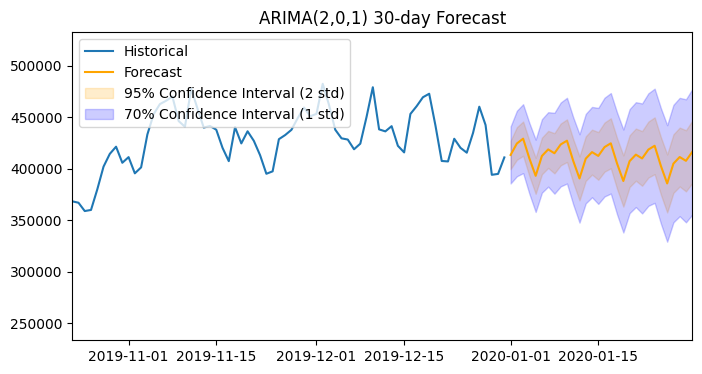

In [222]:
# include seasonality when defining the ARIMA model for daily consumption in Norway
model_arima201 = pm.ARIMA(order=(2,0,1), seasonal_order=(0,1,1,7))
model_arima201 = model_arima201.fit(cons['NO'])

n_periods = 30
#forecast, confint = model_automatic.predict(n_periods=n_periods, return_conf_int=True)

# TRY MULTIPLE CONFIDENCE INTERVALS ON THE SAME PLOT 
forecast, confint_95 = model_arima201.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)  # 95%
forecast, confint_80 = model_arima201.predict(n_periods=n_periods, return_conf_int=True, alpha=0.33)  # 80%

# create index for the forecast that continues from the end of the original series
last_index = cons['NO'].index[-1]

forecast_index = pd.date_range(start=last_index, periods=n_periods+1, freq='D')[1:] # ensure daily frequency
forecast.index = forecast_index # 'forecast' Series had a different index so was not matching in the 'df_forecast' DataFrame

# forecast and confidence intervals into a dataframe
df_forecast_95 = pd.DataFrame({
    'forecast':forecast,
    'lower':confint_80[:, 0],
    'upper':confint_80[:, 1]
}, index=forecast_index)

df_forecast_80 = pd.DataFrame({
    'forecast':forecast,
    'lower':confint_95[:, 0],
    'upper':confint_95[:, 1]
}, index=forecast_index)

# plot historical data and forecast
plt.figure(figsize=(8,4))
# plot original series
plt.plot(cons['NO'].index, cons['NO'], label="Historical")

# plot forecast
plt.plot(df_forecast_95.index, df_forecast_95['forecast'], label='Forecast', color='orange')

plt.fill_between(
    df_forecast_95.index,
    df_forecast_95['lower'],
    df_forecast_95['upper'],
    color='orange',
    alpha=0.2,
    label='95% Confidence Interval (2 std)'
)

# Plot 80% confidence interval
plt.fill_between(
    df_forecast_80.index,
    df_forecast_80['lower'],
    df_forecast_80['upper'],
    color='blue',
    alpha=0.2,
    label='70% Confidence Interval (1 std)'
)

# ensure that the forecast is visible (was not with code above only) so ensure x-range includes forecast indices, too
all_x = pd.concat([cons['NO'].index.to_series(), df_forecast_95.index.to_series()])
"""
all_y = pd.concat([
    DK_df['DK1_price'],
    df_forecast['forecast'],
    df_forecast['lower'],
    df_forecast['upper']
])
plt.ylim(all_y.min(), all_y.max())
"""

plt.xlim(all_x[-100], all_x.max())

plt.legend(loc='upper left')
plt.title("ARIMA(2,0,1) 30-day Forecast")
plt.show()


- Forecasts appear to exhibit seasonal fluctuations, which aligns with the observed patterns.
- However, forecasts seem smoother than the actual data. They do not capture short-term variability (e.g., the random noise). This may be a sign of over-reliance on the seasonal component.
- Related, the confidence intervals are quite narrow (mentioned this before) as it may underestimate uncertainty or overfit to historical data. 

**What may be wrong or missing?**
- Power market data has overlapping seasonalities (daily, weekly, yearly), so these ARIMA models are missing periodic patterns. 
- Exogenous variables, such as temperature, economic activity or weather patterns are not included in the ARIMA model.

Several seasonality patterns will be modelled in future notebooks.

Next, volatility is modelled using GARCH models.

### Modelling volatility: GARCH models

Instead of predicting the mean value of the series, the volatility of time series is of interest when analysing power market (e.g. for hedging instruments). 

ARCH stands for Autoregressive Conditional heteroskedacity. It takes into account non-constant variance in the data. For example, the daily power consumption data appears to have a non-constant variance over time. This could be modelled using an ARCH or GARCH model. 

If we have the following model,

$$
y_t = \beta_0 + \beta_1 x_{t1} + \beta_2 x_{t2} + \dots + \beta_k x_{tk} + u_t,
$$

then we say that the error term follows an ARCH(1) process,

$$
E(u_t^2 | u_{t-1}, u_{t-2}, \dots) = \alpha_0 + \alpha_1 u_{t-1}^2.
$$

The variance (or volatility) at time $t$ is conditional on the variance in $t-1$, and we can model this via OLS.

In ARCH(1) model, the conditional variance of the error term $u_t$, denoted as $\sigma^2_t$, is expressed as,
$$
\sigma_t^2 = \alpha_0 + \alpha_1 u_{t-1}^2.
$$

The variance at time $t$ depends on the squared value of the previous time step error term. $u_t^2$ is used as a proxy for the variance as it is not directly observable. 

For small changes, log returns (i.e. the differences in log values of the series) are approximately equal to percentage returns. For the daily consumption data, we take 7-day differeces instead to capture the weakly seasonal component. It is thus an approximate week-by-week percentage "returns", or changes in consumption. 

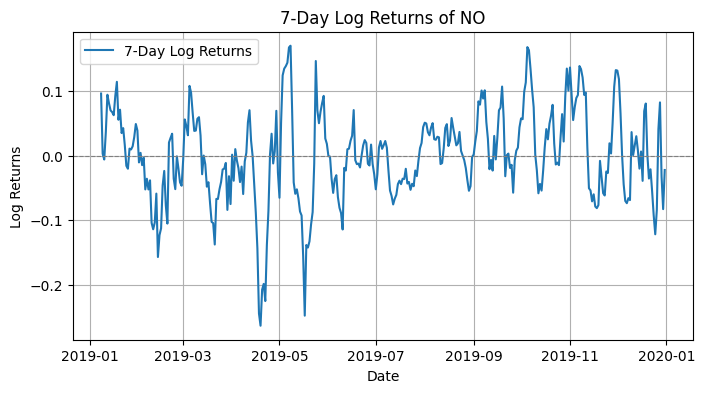

In [263]:
cons_returns = cons.copy()
cons_returns['weekly_returns'] = np.log(cons_returns['NO']).diff(periods=7)
cons_returns.dropna(subset=['weekly_returns'], inplace=True)
plt.figure(figsize=(8, 4))
plt.plot(cons_returns.index, cons_returns['weekly_returns'], label='7-Day Log Returns')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add a reference line at 0
plt.title('7-Day Log Returns of NO')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
plt.show()

Run automatic seasonal ARIMA model

In [233]:
# fit ARIMA automatically using best parameters
model_automatic = pm.auto_arima(
    cons_returns['weekly_returns'],
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=1,
    seasonal=True,            # seasonal ARIMA
    m=7,                      # Weekly seasonality i.e. 7 days
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    D=1,
    trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Gather results for comparison
models = {
    'automatic': model_automatic
}

# results table
results = []
for model_name, fitted_model in models.items():
    # pmdarima models offer .aic(), .bic(), .aicc() methods
    results.append({
        'model': model_name,
        'AIC':   fitted_model.aic(),
        'AICc':  fitted_model.aicc() if hasattr(fitted_model, 'aicc') else None,
        'BIC':   fitted_model.bic()
    })

df_results = pd.DataFrame(results)
df_results.sort_values('AICc', inplace=True, ignore_index=True)

print(df_results)

# identify the best model 
best_model = df_results.iloc[0]['model']
print(f"The best model based on AIC/AICc/BIC is: {best_model}")

p, d, q = model_automatic.order
print(f"Automatically selected (p, d, q) = ({p}, {d}, {q})")

print(model_automatic.summary()) # 208.557662  208.752784  217.090224

       model          AIC         AICc          BIC
0  automatic -1171.862495 -1171.794699 -1160.288696
The best model based on AIC/AICc/BIC is: automatic
Automatically selected (p, d, q) = (0, 1, 0)
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  358
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 7)   Log Likelihood                 588.931
Date:                           Sun, 29 Dec 2024   AIC                          -1171.862
Time:                                   15:53:39   BIC                          -1160.289
Sample:                               01-08-2019   HQIC                         -1167.256
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-

The automatic program finds:
- no non-seasonal AR lags
- two seasonal AR terms for seasonal differencing. The model bases its predictions on 1 and 2 weeks ago (7 and 14 periods ago)

Next, with the residuals, squared residuals are computed and ARCH(1) model is fitted. There is no equivalent `pm.auto_arima` method for ARCH models, but let's start with ARCH(1) fitted on the squared residuals.

Unlike results found by Johannes Moritzen, the lagged squared residuals ($u_{t-1}^2$) are not statistically significant. Let's instead not use the automatic ARIMA model found by `pm` package. Instead, use AR terms of 1 day and 7 days in the ARIMA model. 

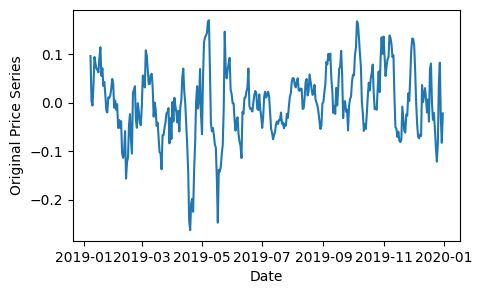

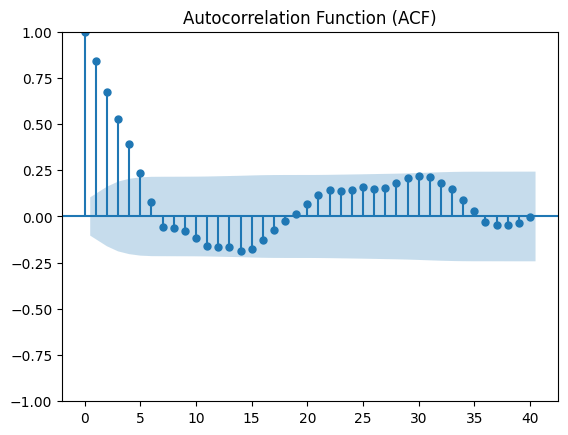

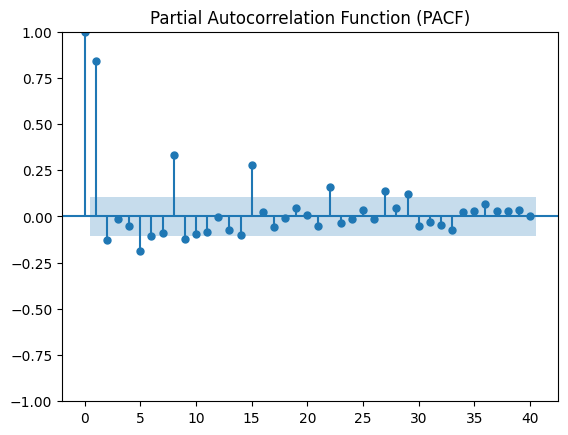

In [242]:
plt.figure(figsize=(5,3))
plt.plot(cons_returns['weekly_returns'])
plt.xlabel('Date')
plt.ylabel('Original Price Series')
plt.show()

# Plot ACF (Autocorrelation Function)
plot_acf(cons_returns['weekly_returns'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF (Partial Autocorrelation Function)
plot_pacf(cons_returns['weekly_returns'], lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

- ACF exponential decay (suggests AR process) + PACF spike at lag 1 = suggests AR(1) process for non-seasonal component
- No significant spikes in ACF suggests no MA i.e. MA(0)
- No differencing as it has been done already by taking the log and differencing

ARIMA(1,0,0)

For the seasonal components of the model,
- The ACF shows a seasonal pattern (significant spikes around every 7 periods so $P = 1$)
- $Q = 0$ as no strong evidence of seasonal MA
- $D=0$ as seasonal differencing has already been addressed.

We fit the ARIMA(1,0,0)(1,0,0) model below.

In [244]:
model_arima100100 = pm.ARIMA(order=(1,0,0), seasonal_order=(1,0,0,7))
model_arima100100 = model_arima100100.fit(cons_returns['weekly_returns'])

# Gather results for comparison
models = {
    'model_arima100100': model_arima100100
}

# results table
results = []
for model_name, fitted_model in models.items():
    # pmdarima models offer .aic(), .bic(), .aicc() methods
    results.append({
        'model': model_name,
        'AIC':   fitted_model.aic(),
        'AICc':  fitted_model.aicc() if hasattr(fitted_model, 'aicc') else None,
        'BIC':   fitted_model.bic()
    })

df_results = pd.DataFrame(results)
df_results.sort_values('AICc', inplace=True, ignore_index=True)

print(df_results)

print(model_arima100100.summary())

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


               model          AIC         AICc          BIC
0  model_arima100100 -1389.004263 -1388.890948 -1373.482131
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  358
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood                 698.502
Date:                           Sun, 29 Dec 2024   AIC                          -1389.004
Time:                                   16:46:36   BIC                          -1373.482
Sample:                               01-08-2019   HQIC                         -1382.831
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
in

- Non-seasonal AR(1) coefficient : highly significant
- Seasonal AR(1) coefficient : highly significant
- Estimated variance of the residuals : low

The final step of the process involves fitting an ARIMA(1,0,0) model on the squared residuals series and find that the autoregressive coefficient for one lag **is** statistically significant.

In [247]:
residuals = model_arima100100.resid()

# compute squared residuals
cons_returns['res_sq'] = residuals**2

# Fit ARIMA(1,0,0) on squared residuals series
arch_model = ARIMA(cons_returns['res_sq'], order=(1, 0, 0)).fit()

# Print the summary of the fitted model
print(arch_model.summary())

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 res_sq   No. Observations:                  358
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1664.409
Date:                Sun, 29 Dec 2024   AIC                          -3322.818
Time:                        17:14:57   BIC                          -3311.176
Sample:                    01-08-2019   HQIC                         -3318.188
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      4.121      0.000       0.001       0.002
ar.L1          0.2776      0.027     10.230      0.000       0.224       0.331
sigma2      5.355e-06   1.83e-07     29.226      0.0

AR(1) coefficient for squared residuals (of seasonal ARIMA fitted on log differenced original series) is **highly statistically significant**. The squared residuals are positively dependent on their previous values (coefficient of 0.28). Large squared residuals (high variance) are likely to be followed by high variance. Note the following:
- Using ordinary regression relies on **constant variance** (homoskedasticity). It is not the case here. The variance changes over time. This change in variance could be accounted for in two ways: 
1. model changing variance directly with ARCH model, or
2. calculate standard errors robust to non-constant variance, i.e. heteroskedasticity (they adjust the variance-covariance matrix so that standard errors are inflated or deflated to account for heteroskedasticity)

- Series is ARCH (that is, series of residuals of the seasonal ARIMA model). Residuals are the unexplained part after accounting for the primary trends, seasonality or autoregressive components. Evidence for "ARCH" process from volatility clustering we just proved with the last ARIMA(1,0,0) fit. Without considering the presence of this clustering, risks involved and consumption swings in turbulent times may be underestimated. 

### Estimating gARCH models by maximum likelihood

Generalised ARCH, or gARCH, allows the variance to be modelled with both AR and MA terms.

We are modelling the variance component as autoregressive in the sense that a period of high variance will tend to be followed by periods of high variance. 

A complete ARCH model is divided into three components:
1. a mean model (e.g. constant mean or an ARX)
2. a volatility process (e.g. a GARCH or an EGARCH process)
3. a distribution for the standardised residuals

The `weekly_returns` Series is to be fit to ARMA(1,1), gARCH(1,1) model.

To simultaneously fit an ARMA-GARCH model, the mean model and the GARCH model are separable. Fit ARMA model to the time series and a GARCH model to the residuals of the ARMA. I believe the arch model library in Python does not support simultaneous ARMA-GARCH fitting, unlike the R package used by Johannes Mauritzen in his lectures.

In [275]:
# 1. fit ARMA model to time series of weekly returns in cons_returns
arma_model = ARIMA(cons_returns['weekly_returns'], order=(1,0,1)).fit()

arma_residuals = arma_model.resid

# fit GARCH(1,1) model to the residuals
garch_model = arch_model(
    arma_residuals,
    mean='Zero', # residuals are already centred
    vol='GARCH',
    p=1,
    q=1

).fit(disp='off')

print(garch_model.summary())

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:                688.728
Distribution:                  Normal   AIC:                          -1371.46
Method:            Maximum Likelihood   BIC:                          -1359.81
                                        No. Observations:                  358
Date:                Mon, Dec 30 2024   Df Residuals:                      358
Time:                        00:29:13   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.3428e-05  3.946e-06      3.403  6.661e-04 [5.

Plotting the conditional volatility

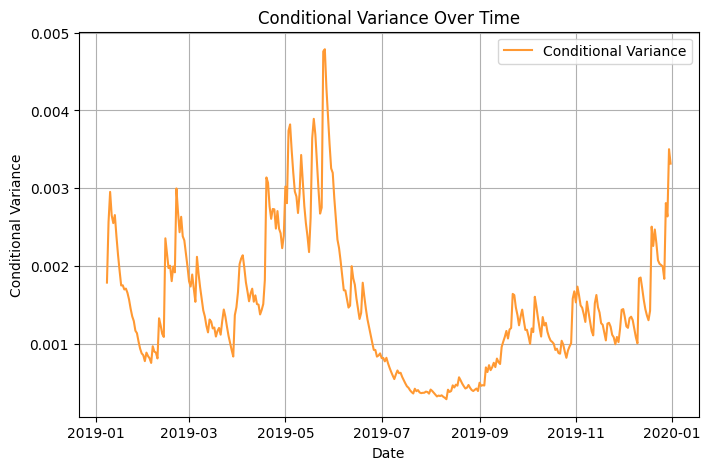

In [277]:
# extract σ_t
conditional_volatility = garch_model.conditional_volatility
# compute σ_t^2
conditional_variance = conditional_volatility ** 2

cons_returns = cons_returns.copy() 
cons_returns['conditional_variance'] = conditional_variance


plt.figure(figsize=(8, 5))
plt.plot(cons_returns.index, cons_returns['conditional_variance'], color='#ff9933', label='Conditional Variance')
plt.title('Conditional Variance Over Time')
plt.xlabel('Date')
plt.ylabel('Conditional Variance')
plt.legend()
plt.grid(True)
plt.show()


The volatility of weekly changes in daily consumption is high in the spring lower in the summer months and rises again in the winter months. 

Spring months may contain more uncertainty in daily consumption as cold and warm days alternate. 

The observed volatility clustering suggests that periods of high variance (spring and winter) tend to persist for some time, followed by periods of lower variance (summer).

Energy supply planning in spring and winter must account for high volatility in daily consumption, while summer periods may focus on efficiency and baseline management.

`GARCH(1,1):` shock to mean system (big residual), we allow that to affect the path of the volatility. Previous period with shock, that can affect the volatility in the next period. Volatility propagates through the AR term. Idea of the dynamics came from the ACF figures. As much art as science. 

Through this model, we have modelled conditional variance. This conditional variance is retrieved with `.conditional_variance` and it is plotted. 

As before, this ARCH model is used to make a forecast. We are currently working with `arma_model` and `garch_model`, both already fitted. The forecasts over 120 periods, or days, are extracted. the former model's forecasts will give us the forecasted mean of the series and the latter will yield the forecasted standard deviation of the series. 

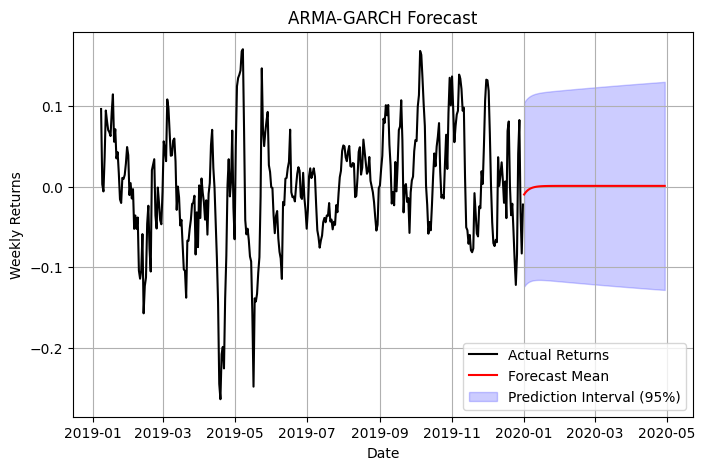

In [283]:
arma_forecast = arma_model.get_forecast(steps=120)
arma_mean_forecast = arma_forecast.predicted_mean

garch_forecast = garch_model.forecast(horizon=120)
garch_std_forecast = garch_forecast.variance.values[-1, :] ** 0.5

# combine ARMA and GARCH forecasts (last date of historical seres is '2019-12-31')
forecast_dates = pd.date_range(start="2020-01-01", periods=120, freq='D')

forecast_df = pd.DataFrame({
    'date':forecast_dates,
    "meanForecast":arma_mean_forecast,
    "standardDeviation":garch_std_forecast
})

# confidence intervals of 2 std, i.e. 95%
forecast_df["lowerBound"] = forecast_df["meanForecast"] - 2 * forecast_df["standardDeviation"]
forecast_df["upperBound"] = forecast_df["meanForecast"] + 2 * forecast_df["standardDeviation"]

# combine with original data for plotting
cons_returns = cons_returns.copy()
cons_returns = cons_returns.reset_index()  # switch 'date' from index to a column

combined_df = pd.concat([
    cons_returns[['date', 'weekly_returns']],
    forecast_df.set_index("date")
], axis=1).reset_index()

plt.figure(figsize=(8, 5))

# Actual returns
plt.plot(combined_df['date'], combined_df['weekly_returns'], label='Actual Returns', color='black')

# Forecasted mean
plt.plot(forecast_df['date'], forecast_df['meanForecast'], label='Forecast Mean', color='red')

# Confidence intervals
plt.fill_between(
    forecast_df['date'],
    forecast_df['lowerBound'],
    forecast_df['upperBound'],
    color='blue',
    alpha=0.2,
    label='Prediction Interval (95%)'
)

# Labels and title
plt.title('ARMA-GARCH Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Returns')
plt.legend()
plt.grid(True)
plt.show()


#### Is this forecast reasonable?

- The forecasted mean (in red) is flat and close to zero. This is partly reasonable because the ARMA-GARCH model assumes that the mean of the residuals (after removing ARMA dynamics) is approximately zero. The prediction intervals widen as the forecast horizon increases. Uncertainty grows with time. 

However, the flat mean might underestimate dynamics in the data. I suspect this is due to not including a seasonal term in the ARIMA(1,0,1) model. 

Let's go back a step and ensure that the ARMA(1,1) residuals are white noise (uncorrelated and zero mean)


Mean of residuals: -0.00019249126068966363
Ljung-Box Test Results:
      lb_stat     lb_pvalue
10  62.659543  1.133559e-09


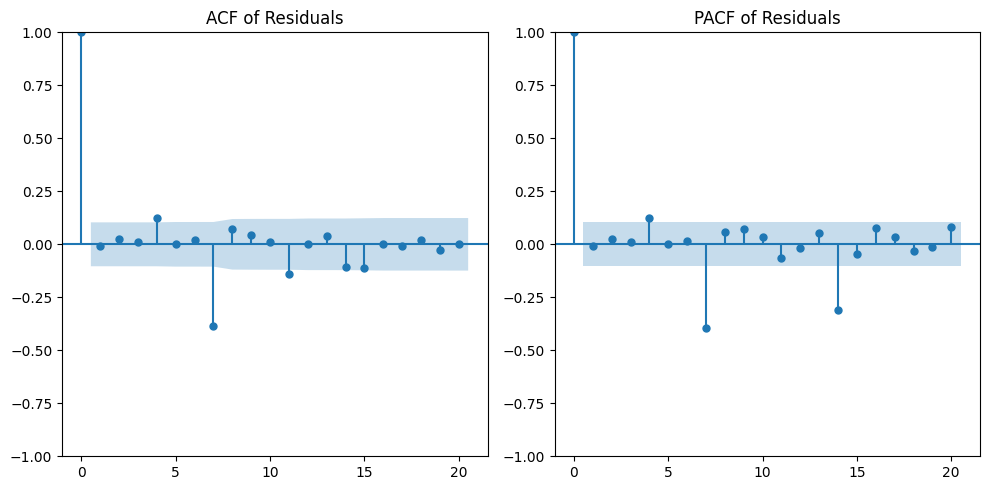

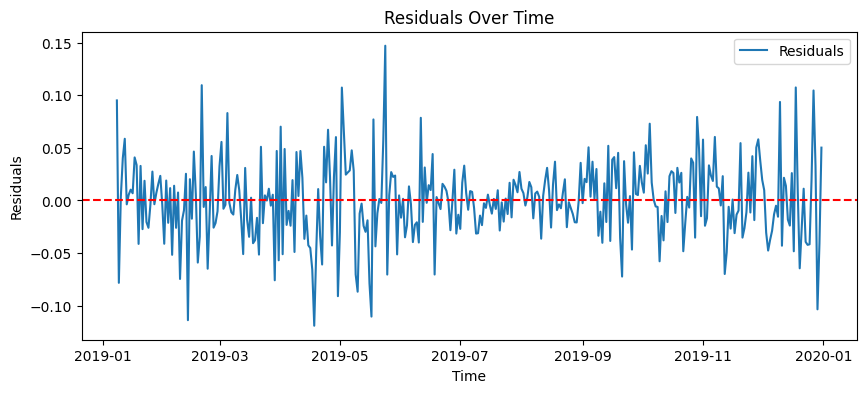

In [286]:
residual_mean = arma_residuals.mean()
print(f"Mean of residuals: {residual_mean}")

# perform Ljung-Box test for autocorrelation
# null hypothesis: Residuals are uncorrelated
ljung_box_result = acorr_ljungbox(arma_residuals, lags=[10], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_result)

# plot ACF and PACF of residuals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_acf(arma_residuals, lags=20, ax=plt.gca(), title='ACF of Residuals')

plt.subplot(1, 2, 2)
plot_pacf(arma_residuals, lags=20, ax=plt.gca(), title='PACF of Residuals')

plt.tight_layout()
plt.show()

# check for homoscedasticity visually (plot residuals over time)
plt.figure(figsize=(10, 4))
plt.plot(arma_residuals, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [287]:
# the residuals from ARMA(1,1) are stationary
adf_test = adfuller(arma_residuals)
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-value: {adf_test[1]}")

ADF Statistic: -5.8770183445455055
P-value: 3.142090053673201e-07


This suggests the residuals are centred around zero.

However, the ARMA model may be misspecified, as shown by the significant Ljung-Box test. The residuals still exhibit autocorrelation, which violates the assumptions for fitting a GARCH model. We see that there are large spikes at multplies of lag=7, so modify the ARMA to seasonal ARMA. 
#### Attempt to include seasonality in the ARMA(1,1) model
I am going to try again with a seasonal ARIMA model, whose residuals will be used to fit the GARCH model.

In [289]:
# adding seasonal term to address spikes in ACF and pACF at multiples of 7 periods in residuals of non-seasonal ARMA(1,1)

sarima_model = SARIMAX(
    cons_returns['weekly_returns'],  # Time series data
    order=(1, 0, 1),                 # Non-seasonal ARIMA terms
    seasonal_order=(1, 0, 1, 7)      # Seasonal terms with period 7 (weekly)
).fit(disp=False)

# Print SARIMA summary
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    weekly_returns   No. Observations:                  358
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                 760.585
Date:                           Mon, 30 Dec 2024   AIC                          -1511.171
Time:                                   16:14:30   BIC                          -1491.768
Sample:                                        0   HQIC                         -1503.454
                                           - 358                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9916      0.011     89.274      0.000       0.970       1.013
ma.L1          0.1065      0.042      2.564

Seasonal AR(7) term is not significant so model is changed to SARIMA(1,0,1)(0,0,1)[7]

In [291]:
sarima_model = SARIMAX(
    cons_returns['weekly_returns'],
    order=(1, 0, 1),         # Non-seasonal ARIMA terms
    seasonal_order=(0, 0, 1, 7)  # Seasonal terms
).fit(disp=False)

# Print the summary of the updated SARIMA model
print(sarima_model.summary())

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                    weekly_returns   No. Observations:                  358
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood                 760.334
Date:                           Mon, 30 Dec 2024   AIC                          -1512.668
Time:                                   16:20:30   BIC                          -1497.146
Sample:                                        0   HQIC                         -1506.495
                                           - 358                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9907      0.011     89.055      0.000       0.969       1.013
ma.L1          0.1055      0.042      2.532

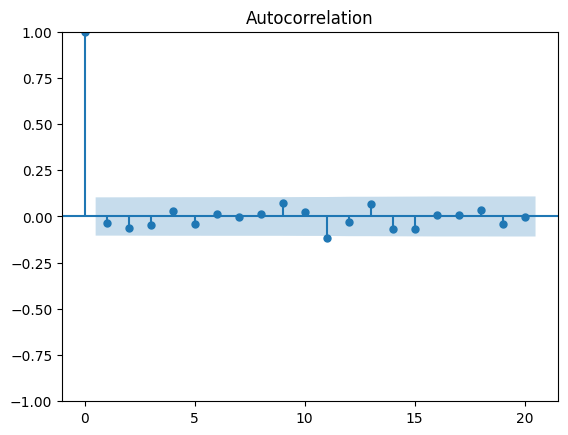

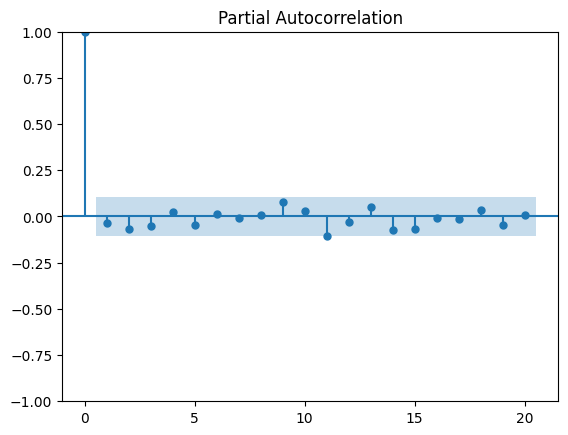

In [292]:
sarima_residuals = sarima_model.resid

plot_acf(sarima_residuals, lags=20)
plot_pacf(sarima_residuals, lags=20)
plt.show()

This looks better, no large spikes at any lag except lag=0 (A.C with series itself)

Next, fit GARCH(1,1) model on these SARIMA residuals.

In [293]:
garch_model = arch_model(
    sarima_residuals,
    mean='Zero', # residuals are already centred
    vol='GARCH',
    p=1,
    q=1

).fit(disp='off')

print(garch_model.summary())

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008641. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:                770.458
Distribution:                  Normal   AIC:                          -1534.92
Method:            Maximum Likelihood   BIC:                          -1523.27
                                        No. Observations:                  358
Date:                Mon, Dec 30 2024   Df Residuals:                      358
Time:                        16:23:32   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.1669e-04  2.025e-04      1.564      0.118 

- $\alpha_1 \text{ p-value} = 0.017$ suggests that recent shocks have significant impact on current volatility.
- $\beta_1 \text{ p-value} = 0.19$ suggests moderate persistence over time. This can be seen in the conditional volatility plotted below.

Plotting conditional volatility of GARCH model

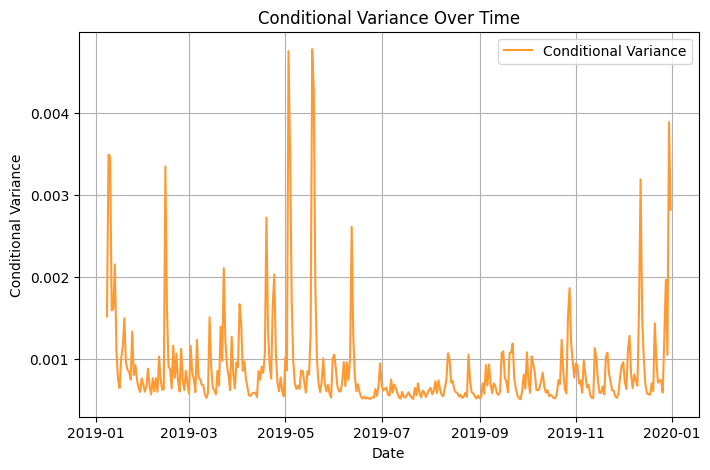

In [299]:
# extract σ_t
conditional_volatility = garch_model.conditional_volatility
# compute σ_t^2
conditional_variance = conditional_volatility ** 2

cons_returns = cons_returns.copy() 
cons_returns['conditional_variance'] = conditional_variance


plt.figure(figsize=(8, 5))
plt.plot(cons_returns['date'], cons_returns['conditional_variance'], color='#ff9933', label='Conditional Variance') # index got reset so use column 'date'
plt.title('Conditional Variance Over Time')
plt.xlabel('Date')
plt.ylabel('Conditional Variance')
plt.legend()
plt.grid(True)
plt.show()

There is evidence of volatiltiy clustering, but it appears less persistent than with the GARD model fitted on the residuals of ARMA(1,1), as shown above with the p values.

Final check: residuals of the GARCH model

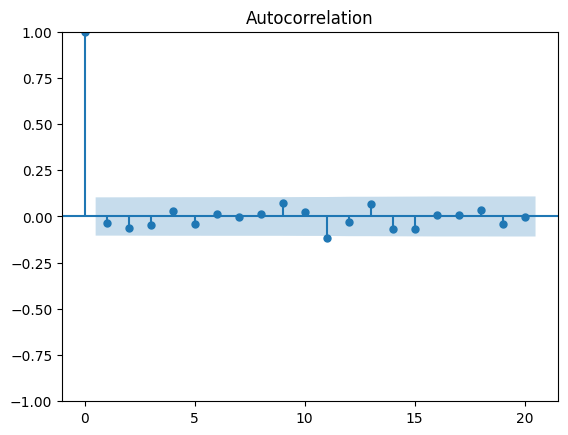

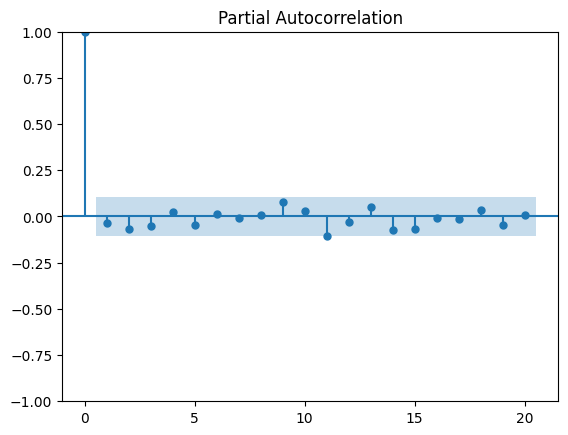

    lb_stat  lb_pvalue
10  6.04499   0.811469


In [300]:
# Residuals from the GARCH model
garch_residuals = garch_model.resid

# Plot ACF and PACF
plot_acf(garch_residuals, lags=20)
plot_pacf(garch_residuals, lags=20)
plt.show()

# Ljung-Box test
ljung_box = acorr_ljungbox(garch_residuals, lags=[10], return_df=True)
print(ljung_box)

The null-hypothesis of the Ljung-Box test is that the residuals are uncorrelated up to specified (lag 10 in our case). High p-value of $0.811$ means we fail to reject the null hypothesis and the residuals of the GARCH model fit to the residuals of the SARIMA model. With white noise residuals, we can use the GARCH model for forecasting conditional volatility.

Forecasting using SARIMA-GARCH model

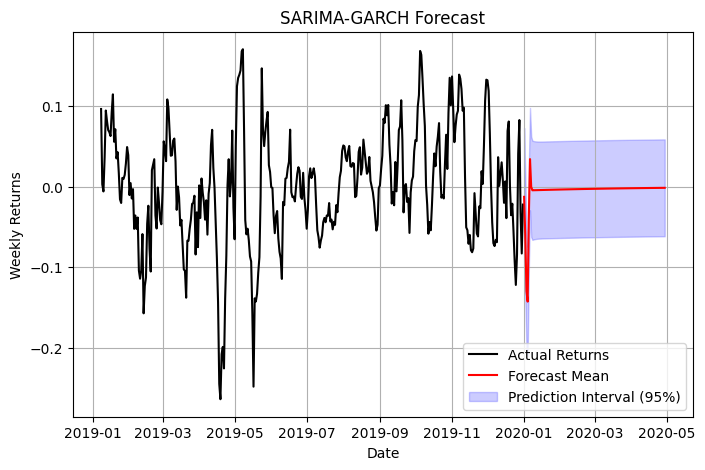

In [297]:
sarima_forecast = sarima_model.get_forecast(steps=120)
arma_mean_forecast = sarima_forecast.predicted_mean

garch_forecast = garch_model.forecast(horizon=120)
garch_std_forecast = garch_forecast.variance.values[-1, :] ** 0.5

# combine ARMA and GARCH forecasts (last date of historical seres is '2019-12-31')
forecast_dates = pd.date_range(start="2020-01-01", periods=120, freq='D')

forecast_df = pd.DataFrame({
    'date':forecast_dates,
    "meanForecast":arma_mean_forecast,
    "standardDeviation":garch_std_forecast
})

# confidence intervals of 2 std, i.e. 95%
forecast_df["lowerBound"] = forecast_df["meanForecast"] - 2 * forecast_df["standardDeviation"]
forecast_df["upperBound"] = forecast_df["meanForecast"] + 2 * forecast_df["standardDeviation"]

# combine with original data for plotting
cons_returns_sarima = cons_returns.copy()
#cons_returns = cons_returns.reset_index()  # switch 'date' from index to a column

combined_df = pd.concat([
    cons_returns_sarima[['date', 'weekly_returns']],
    forecast_df.set_index("date")
], axis=1).reset_index()

plt.figure(figsize=(8, 5))

# Actual returns
plt.plot(combined_df['date'], combined_df['weekly_returns'], label='Actual Returns', color='black')

# Forecasted mean
plt.plot(forecast_df['date'], forecast_df['meanForecast'], label='Forecast Mean', color='red')

# Confidence intervals
plt.fill_between(
    forecast_df['date'],
    forecast_df['lowerBound'],
    forecast_df['upperBound'],
    color='blue',
    alpha=0.2,
    label='Prediction Interval (95%)'
)

# Labels and title
plt.title('SARIMA-GARCH Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Returns')
plt.legend()
plt.grid(True)
plt.show()

The forecast starts with high variance immediately after the historical data ends. This is consistent with the high conditional variance observed in the SARIMA residuals towards the end of the historical data (end of 2019).

The variance of forecast quickly flattens over time (similarly to the ARMA-GARCH forecast). This indicates that the GARCH(1,1) model assumes volatility reverts to a baseline level quickly (mean-reversion). This aligns with the low persistence result we got in the GARCH model summary. This insignificant $\beta_1$ term with small value of $0.36$ limits the persistence of volatility clustering, causing the variance to stabilise quickly. 

The flat red line shows that the SARIMA model assumes no significant upward or downward trends in the weekly returns. 

Perhaps, giving the GARCH model more flexibility, e.g. GARCH(1,2) or GARCH(2,1) could help it better capture long-term volatility persistence. 

In [302]:
import nbformat
import pyperclip

# Path to your notebook file
notebook_path = "Part5.ipynb"

# Load the notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

# Extract all cell contents
all_cells = []
for cell in notebook['cells']:
    if cell['cell_type'] == 'code':
        all_cells.append(cell['source'])
    elif cell['cell_type'] == 'markdown':
        all_cells.append(cell['source'])

# Print or save the extracted content
full_text = "\n\n".join(all_cells)

pyperclip.copy(full_text)
print("Notebook content has been copied to the clipboard. You can now paste it using Cmd+V or Ctrl+V.")

Notebook content has been copied to the clipboard. You can now paste it using Cmd+V or Ctrl+V.
